In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats

In [2]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['__xarray_dataarray_variable__']
G_CDR_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']


In [3]:
G_ds = xr.concat([G_ds, -G_CDR_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))
G_ds.name = 'G[tas]'
G_ds = G_ds.rename({'year':'s'})


In [5]:
#define our weights for models (grouping UKESM and CANESM realizations)
G_model_weights = utils.G_model_weights

In [7]:
A = utils.A

In [8]:
GF = G_ds.weighted(G_model_weights).mean(dim = ['model', 'pulse_type']) #.weighted(A).mean(dim = ['lat','lon'])

In [47]:
df_emis = pd.read_excel('en_roads_co2_emis_example.xlsx', header = 1, index_col = 0)


In [48]:
kgCO2_to_kgC = 1/3.67 #kg to kg
dt = 1 #year

In [49]:
## convert to GtC from GtCO2/year
df_emis = df_emis * kgCO2_to_kgC * dt

In [51]:
%%time
conv_enroads = {}

for nm in list(df_emis.columns):   
    conv_enroads[nm] = signal.convolve(np.array(df_emis[nm].values)[..., None, None], np.array(GF), 'full')
    conv_enroads[nm] = utils.np_to_xr(conv_enroads[nm], GF, df_emis[nm].values)

CPU times: user 990 ms, sys: 507 ms, total: 1.5 s
Wall time: 1.5 s


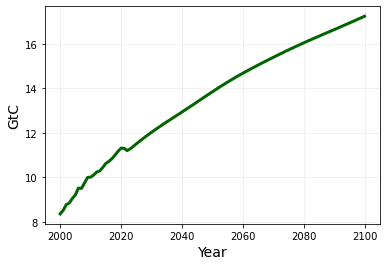

In [90]:
fig, ax = plt.subplots()
plt.plot(df_emis['Baseline'], color = 'darkgreen', linewidth = 3)
plt.ylabel('GtC', fontsize = 14)
plt.xlabel('Year', fontsize = 14)
plt.grid(alpha = 0.2)

In [9]:
GF

<xarray.DataArray 'G[tas]' (s: 241, lat: 180, lon: 360)>
array([[[ 0.0019789 ,  0.00200375,  0.00200001, ...,  0.00194145,
          0.00196924,  0.00197461],
        [ 0.00181093,  0.00183734,  0.00184216, ...,  0.00176969,
          0.00180463,  0.00180887],
        [ 0.00226652,  0.00229276,  0.00229734, ...,  0.00220692,
          0.00225197,  0.00226002],
        ...,
        [ 0.00239225,  0.00239998,  0.0024163 , ...,  0.00237533,
          0.00237041,  0.00238137],
        [ 0.00287059,  0.00286926,  0.00287932, ...,  0.00286498,
          0.00285192,  0.0028599 ],
        [ 0.00352801,  0.00352446,  0.00353073, ...,  0.00354368,
          0.00352686,  0.00352592]],

       [[ 0.00505913,  0.00504135,  0.00504164, ...,  0.00509253,
          0.00506997,  0.00506434],
        [ 0.00499389,  0.00497412,  0.00497768, ...,  0.00501361,
          0.00499766,  0.004996  ],
        [ 0.00528648,  0.00527441,  0.00528603, ...,  0.00528757,
          0.00527989,  0.00528395],
...
        [-0.00466582, -0.00477523, -0.00477523, ..., -0.00453214,
         -0.00464303, -0.0046545 ],
        [-0.00466582, -0.00477523, -0.00477523, ..., -0.00453214,
         -0.00464303, -0.0046545 ],
        [-0.00466582, -0.00477523, -0.00477523, ..., -0.00453214,
         -0.00464303, -0.0046545 ]],

       [[ 0.00551264,  0.00559451,  0.00559451, ...,  0.00540709,
          0.00549507,  0.00550417],
        [ 0.00551264,  0.00559451,  0.00559451, ...,  0.00540709,
          0.00549507,  0.00550417],
        [ 0.00551264,  0.00559451,  0.00559451, ...,  0.00540709,
          0.00549507,  0.00550417],
        ...,
        [-0.00077116, -0.00072211, -0.00072211, ..., -0.00082558,
         -0.00078086, -0.00077623],
        [-0.00077116, -0.00072211, -0.00072211, ..., -0.00082558,
         -0.00078086, -0.00077623],
        [-0.00077116, -0.00072211, -0.00072211, ..., -0.00082558,
         -0.00078086, -0.00077623]]])
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 7 8 ... 232 233 234 235 236 237 238 239 240
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

Text(0.5, 1.0, '')

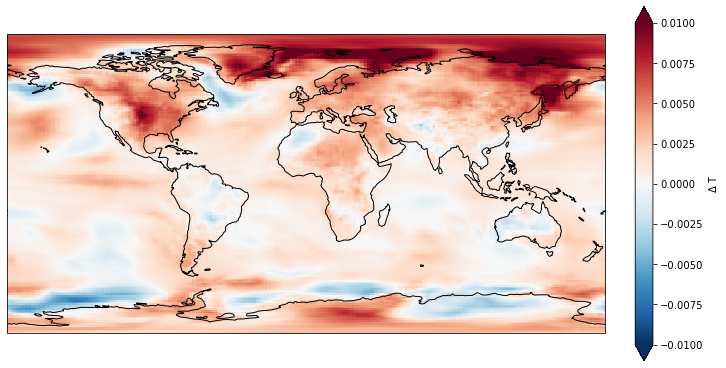

In [12]:
t = 50
fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

##########1pct exp##################

(GF).isel(s = t).plot(ax = ax, 
                      cmap = 'RdBu_r',  extend = 'both', vmin = -.01, vmax = .01, 
                      add_colorbar = True,  cbar_kwargs = {'label':'$\Delta$ T'},   
                      transform = ccrs.PlateCarree())
ax.coastlines()
plt.title(None)

## Video of the GF

In [14]:
for t in np.arange(0,51):
    fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

    ##########1pct exp##################

    (GF).isel(s = t).plot(ax = ax, 
                          cmap = 'RdBu_r',  extend = 'both', vmin = -.01, vmax = .01, 
                          add_colorbar = True,  cbar_kwargs = {'label':'G'},   
                          transform = ccrs.PlateCarree())
    ax.coastlines()
    plt.title(f'{t} years since pulse')
    plt.savefig(f'./figures/video_GF/{t:04d}.png', bbox_inches = 'tight', dpi = 350)
    plt.close()


## Video of the scenarios

In [88]:
for t in np.arange(0,51):
    fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

    ##########1pct exp##################

    (conv_enroads['Baseline']).isel(s = t).plot(ax = ax, 
                                                  cmap = 'RdBu_r',  extend = 'both', vmin = -4, vmax = 4,
                                                  add_colorbar = True,  cbar_kwargs = {'label':'$\Delta$ T ($\degree$ C)'},   
                                                  transform = ccrs.PlateCarree())
    ax.coastlines()
    plt.title(f'{t} years')
    plt.savefig(f'./figures/enroads_video/{t:04d}.png', bbox_inches = 'tight', dpi = 350)
    plt.close()
